Differences from v1: 

1. Changed labels to be lowercase after first word, per Nature guidelines
2. Generated the figure for the main text on its own
3. Placed plots entirely side-by-side
4. Changed figure size for main text to 180 mm wide x 170 mm high, per Nature guidelines

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
from Trajectory import Trajectory
sys.path.insert(1,'../code/data_utils/')
from ConfigDataset import ConfigDataset
from HiCDataset import HiCDataset
from HiCMap import HiCMap
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
config_fp = '../data/processed_data.hdf5'
num_bins = 64
resolution = 20_000
mean_dist_fp = '../data/mean_dists.pt'
mean_sq_dist_fp='../data/squares.pt'

mcool_fp = '../data/outside/GM12878_hg19.mcool'
interp_nans = False
balance_hic = True
adaptive_coarsegraining = False
adaptive_coarsegraining_cutoff = 3
adaptive_coarsegraining_max_levels = 8

save_dir = './maps_vs_tan_hic_v3/'

# Gen configs
config_directory = '../data/samples/origami_64_no_embed_reduction/eval_mode/'
aligned_config_directory = '../data/samples/origami_64_no_embed_reduction/eval_mode/aligned/'
cond_scale = 5.0
rescaled_phi = 8.0
milestone = 120
resolution = 20_000

# For loading dcd files
topology_file = aligned_config_directory+'topology.psf'

regions = { # chrom:region_idxs
  '1':[144,166,200,265,330,395,460,525,590,730,795,860,1260,1325], 
  'X':[100,236,381,445,553,610,675,810,900,965,1060,1100,1125,1200,1243]
}

Load the Dip-C coordinates

In [3]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=num_bins,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,#[chrom for chrom in regions],
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)
rosetta = pd.read_pickle(f'../data/embeddings_{num_bins}_after_transformer/rosetta_stone.pkl')

Load the cooler data

In [4]:
exp_hic = HiCDataset(mcool_fp,resolution=resolution)

Support functions

In [5]:
def get_genomic_index(chrom,region_idx,rosetta=rosetta):
    return rosetta[chrom][region_idx][-1]

In [6]:
def get_experimental_hic(
    chrom,
    region_idx,
    exp_hic=exp_hic,
    resolution=resolution,
    num_bins=num_bins,
    balance=balance_hic,
    adaptive_coarsegraining=adaptive_coarsegraining,
    adaptive_coarsegraining_cutoff=adaptive_coarsegraining_cutoff,
    adaptive_coarsegraining_max_levels=adaptive_coarsegraining_max_levels,
    interp_nans=interp_nans
):
    start = get_genomic_index(chrom,region_idx)
    stop = start + resolution * num_bins
    return exp_hic.fetch(
        chrom=chrom,
        start=start,
        stop=stop,
        balance=balance,
        adaptive_coarsegraining=adaptive_coarsegraining,
        adaptive_coarsegraining_cutoff=adaptive_coarsegraining_cutoff,
        adaptive_coarsegraining_max_levels=adaptive_coarsegraining_max_levels,
        interp_nans=interp_nans
    )

In [7]:
def get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone):
    if filepath is None:
        filepath = config_directory + f'/sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
    gen_configs = torch.load(filepath)
    gen_configs = gen_configs[gen_configs.isfinite().all(-1).all(-1)]
    if gen_configs.shape[-1] == 3:
        gen_configs = Coordinates(gen_configs).distances
    else:
        gen_configs = Distances(gen_configs)
    return gen_configs.float_().cpu_()

In [8]:
def get_tan_dists(chrom,region_idx,config_ds=config_ds):
    chrom = str(chrom)
    start_idx = get_genomic_index(chrom,region_idx) # Get starting position by bp position
    return Coordinates(config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)[1]).distances.float_().cpu_(), start_idx

#### Plotting function -- Just Hi-C & population-average distances

In [9]:
def gen_vs_tan(
    chrom=None,
    region_idx=None,
    config_directory=config_directory,
    *,
    gen_configs = None,
    tan_configs = None,
    filepath=None,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    resolution=20_000
):

    hic_map = get_experimental_hic(chrom,region_idx)
    
    if gen_configs is None:
        gen_configs = get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone)
    gen_mean = gen_configs.mean
    #gen_std = gen_configs.std
    del gen_configs

    if tan_configs is None:
        tan_configs, genomic_index = get_tan_dists(chrom,region_idx)
    else:
        genomic_index = get_genomic_index(chrom,region_idx)
    tan_mean = tan_configs.mean
    #tan_std = tan_configs.std
    del tan_configs

    fig = plt.figure(figsize=(6.5,2.25))

    hic_ax = fig.add_subplot(121)
    _,_,hic_im,hic_cbar = hic_map.plot(fig=fig,ax=hic_ax,vmax=1)
    hic_ax.set_title('Experimental Hi-C')
    #hic_cbar.set_label('')#Experimental Contact\nProbabilities')
    #hic_cbar.set_label('Interaction Frequency')
    
    dist_ax = fig.add_subplot(122)
    _,_,dist_im,dist_cbar = tan_mean.plot_with(gen_mean,fig=fig,ax=dist_ax)
    dist_ax.set_title('Population average')
    #dist_cbar.set_label('')

    '''
    std_ax = fig.add_subplot(133)
    _,_,std_im,std_cbar = tan_std.plot_with(gen_std,fig=fig,ax=std_ax)
    '''

    n = tan_mean.num_beads
    fig.suptitle(
        #'Distance Statistics Comparison:\n'+\
        f'Chromosome {chrom}: {genomic_index:,}-{genomic_index+resolution*n:,}',
        verticalalignment='bottom'
    )

    for ax in [dist_ax]:
        
        ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
        
        ax.text(.005*n,.995*n-1,'ChromoGen',horizontalalignment='left',verticalalignment='baseline',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    return fig, dist_ax, dist_im, dist_cbar, hic_ax, hic_im, hic_cbar
    

Make all of the plots

In [10]:
if save_dir == '':
    save_dir = './'
if save_dir[-1] != '/':
    save_dir+= '/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for chrom in regions:
    for region_idx in regions[chrom]:
        try:
            fig,*_ = gen_vs_tan(
                chrom,
                region_idx,
                cond_scale=cond_scale,
                rescaled_phi=rescaled_phi
            )
            #fig.savefig(save_dir + f'chrom_{chrom}_region_{region_idx}_nbins_{num_bins}_scale_{cond_scale}_phi_{rescaled_phi}.pdf',bbox_inches='tight');
        except:
            pass
        break

#### Also show distance map from aligned structures

In [11]:
def get_gen_coords(chrom=None,region_idx=None,cond_scale=cond_scale,rescaled_phi=rescaled_phi,milestone=milestone,filepath=None):
    if filepath is None:
        filepath = config_directory + f'/sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
    gen_configs = torch.load(filepath)
    gen_configs = gen_configs[gen_configs.isfinite().all(-1).all(-1)]
    assert gen_configs.shape[-1] == 3, 'Not coordinates'
    gen_configs = Coordinates(gen_configs)
    return gen_configs


In [12]:
def get_genomic_index(chrom,region_idx,rosetta=rosetta):
    return rosetta[chrom][region_idx][-1]
    
def get_tan_coords(chrom,region_idx,config_ds=config_ds):
    chrom = str(chrom)
    start_idx = get_genomic_index(chrom,region_idx) # Get starting position by bp position
    return Coordinates(config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)[1]).float_(), start_idx

In [13]:
'''
def get_best_match(tan_configs,gen_configs):

    rmsd_index,aligned_configs = gen_configs.trajectory.get_best_superpositions(tan_configs.trajectory)
    rmsd = rmsd_index['RMSD']
    #index = rmsd_index['Index'] # Index in context of larger gen_configs object, which isn't strictly necessary anymore

    idx = torch.where(rmsd==rmsd.min())[0]
    tan_config = tan_configs[idx].trajectory
    aligned_config = aligned_configs[idx].trajectory

    tan_config.mdtraj.center_coordinates()
    aligned_config.superpose(tan_config)

    return aligned_config, tan_config
'''

def get_best_match(tan_configs,gen_configs):

    gen_configs = gen_configs.trajectory
    tan_configs = tan_configs.trajectory
    tan_configs.mdtraj.center_coordinates()

    # Find the best superposition for each reference conformation
    normed_rmsd_index1,aligned_configs1 = gen_configs.get_best_superpositions(tan_configs)
    normed_rmsd1 = normed_rmsd_index1['Normed RMSD']

    # Check the reflections since we cannot distinguish mirror images when converting distance maps to coordinates
    gen_configs.mdtraj.xyz[:,:,-1]*= -1
    normed_rmsd_index2,aligned_configs2 = gen_configs.get_best_superpositions(tan_configs)
    normed_rmsd2 = normed_rmsd_index2['Normed RMSD']

    if normed_rmsd2.min() < normed_rmsd1.min():
        normed_rmsd = normed_rmsd2
        aligned_configs = aligned_configs2
    else:
        normed_rmsd = normed_rmsd1
        aligned_configs = aligned_configs2

    idx = torch.where(normed_rmsd.min()==normed_rmsd.min())[0]
    tan_config = tan_configs[idx]
    tan_config.mdtraj.center_coordinates()
    aligned_config = aligned_configs[idx].superpose(tan_config)

    return aligned_config, tan_config
    

In [14]:
def get_filename(
    chrom,
    region_idx,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone
):
    return f'sample_{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pt'

In [15]:
def load_get_save_best_match(
    chrom,
    region_idx,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    num_bins=num_bins,
    config_directory=config_directory,
    aligned_config_directory=aligned_config_directory,
    filepath=None
):

    if filepath is not None:
        config_directory = '/'.join(filepath.split('/')[:-1]) + '/'
        aligned_config_directory = config_directory + 'aligned/'
        f = filepath.split('/')[-1]
    else:
        f = get_filename(chrom,region_idx,cond_scale,rescaled_phi,milestone)
    f = f.replace('.pt','.dcd')
    tan_f = f.replace('.dcd','_tan.dcd')
    acd = aligned_config_directory
    if (chrom == '1' and region_idx == 395) or (chrom == 'X' and region_idx == 1243):
        acd = '../data/samples/origami_64_no_embed_reduction/eval_mode/aligned_no_reflections_checked/'
    if os.path.exists(acd+f) and os.path.exists(acd+tan_f):
        gen_config = Trajectory(acd+f,num_beads=num_bins)
        tan_config = Trajectory(acd+tan_f,num_beads=num_bins)
        genomic_index = get_genomic_index(chrom,region_idx)
        return gen_config, tan_config, genomic_index

    elif not os.path.exists(acd):
        os.makedirs(acd)

    # The files didn't exist; must load all coordinates and align them
    gen_configs = get_gen_coords(filepath=config_directory+f.replace('.dcd','.pt'))
    tan_configs, genomic_index = get_tan_coords(chrom,region_idx)

    gen_config,tan_config = get_best_match(tan_configs,gen_configs)
    
    gen_config.trajectory.save_dcd(acd+f)
    tan_config.trajectory.save_dcd(acd+tan_f)

    return gen_config, tan_config, genomic_index

In [16]:
def plot_best_match(
    chrom,
    region_idx,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    num_bins=num_bins,
    resolution=resolution,
    fig=None,
    ax=None,
    cbar_orientation=None,
    filepath=None
):
    gen_config,tan_config,start = load_get_save_best_match(chrom,region_idx,cond_scale,rescaled_phi,milestone,filepath=filepath)

    # Convert to nm
    gen_config = type(gen_config)(gen_config.values*100)
    tan_config = type(tan_config)(tan_config.values*100)

    if fig is None or ax is None:
        fig = plt.figure(figsize=(3.25,2.1))
        ax = fig.add_subplot(111)

    tan_config = tan_config.distances
    gen_config = gen_config.distances
    if cbar_orientation is None:
        cbar_ticks = None
    else:
        cbar_tick_max = int(max(tan_config.values.max(),gen_config.values.max())//100 * 100)
        cbar_ticks=[0,cbar_tick_max]
    _,_,im,cbar = tan_config.plot_with(gen_config,fig=fig,ax=ax,cbar_orientation=cbar_orientation,cbar_ticks=cbar_ticks)

    ''' # Performed in gen_vs_tan_2()
    n = gen_config.num_beads
    ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    
    ax.text(.005*n,.995*n-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    '''
    
    '''
    stop = start + num_bins*resolution
    start//= 1e6
    stop//= 1e6
    ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start}-{stop} Mb')
    '''
    #ax.set_title('Aligned conformation')

    return fig, ax, im, cbar
    
    

#### Updated plotting function -- Hi-C, population-averaged distances, and aligned single-cell distances

In [17]:
def gen_vs_tan_2(
    chrom=None,
    region_idx=None,
    fraction_w1=0.5,
    *,
    gen_configs = None,
    tan_configs = None,
    filepath=None,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    resolution=20_000,
    config_directory=config_directory,
    ax_titles=True,
    fig=None,
    hic_ax=None,
    dist_ax=None,
    fit_ax=None,
    cbar_orientation=None
):

    hic_map = get_experimental_hic(chrom,region_idx)
    '''
    if gen_configs is None:
        if filepath is None:
            gen_configs = get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone)
        else:
            gen_configs = Coordinates(filepath).distances
    '''
    
    gen_mean = get_gen_dists(filepath,chrom,region_idx,cond_scale=1.,rescaled_phi=0.,milestone=milestone).mean
    gen_mean._values*= fraction_w1
    gen_mean._values+= get_gen_dists(
        filepath,chrom,region_idx,cond_scale=5.,rescaled_phi=8.,milestone=milestone
    ).mean.values * (1-fraction_w1)
    gen_mean._values*= 100 # to nm
    
    #gen_std = gen_configs.std
    #del gen_configs1, gen_configs2

    if tan_configs is None:
        tan_configs, genomic_index = get_tan_dists(chrom,region_idx)
    else:
        genomic_index = get_genomic_index(chrom,region_idx)
    tan_configs = Distances(tan_configs.values*100) # convert to nm
    tan_mean = tan_configs.mean
    #tan_std = tan_configs.std
    del tan_configs

    if fig is None or hic_ax is None or dist_ax is None or fit_ax is None:
        if cbar_orientation is None:
            fig,(hic_ax,dist_ax,fit_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.6,6.692*.25),layout="constrained")
        else:
            fig,(hic_ax,dist_ax,fit_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.5,6.692*.25),layout="constrained")
    
    _,_,hic_im,hic_cbar = hic_map.plot(fig=fig,ax=hic_ax,vmax=1,cbar_orientation=cbar_orientation)

    if cbar_orientation is None:
        cbar_ticks = None
    else:
        cbar_tick_max = int(max(tan_mean.values.max(),gen_mean.values.max())//100 * 100)
        cbar_ticks = [0,cbar_tick_max]
    _,_,dist_im,dist_cbar = tan_mean.plot_with(gen_mean,fig=fig,ax=dist_ax,cbar_orientation=cbar_orientation,cbar_ticks=cbar_ticks)
    dist_ax.set_ylabel('')

    _,_,fit_im,fit_cbar = plot_best_match(chrom,region_idx,cond_scale,rescaled_phi,milestone,filepath=filepath,fig=fig,ax=fit_ax,cbar_orientation=cbar_orientation)
    fit_ax.set_ylabel('')
    
    hic_cbar.set_label('')
    dist_cbar.set_label('')
    fit_cbar.set_label('')

    n = tan_mean.num_beads
    start_Mb = round(genomic_index/1e6,3)
    stop_Mb = round((genomic_index+resolution*n)/1e6,3)
    fig.suptitle(
        '\n'+f'Chromosome {chrom}: {start_Mb}-{stop_Mb} Mb',
        verticalalignment='center'
    )

    for ax in [dist_ax,fit_ax]:
        
        ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],fontsize='small')
        
        ax.text(.005*n,.995*n-1,'ChromoGen',horizontalalignment='left',verticalalignment='baseline',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],fontsize='small')

    return fig, dist_ax, dist_im, dist_cbar, hic_ax, hic_im, hic_cbar
    

chrom='1'
region_idx=395
fig,*_ = gen_vs_tan_2(
    '15',#'3',#'4',#chrom,
    1322,#100,#77,#region_idx,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    cbar_orientation='horizontal'
)

In [18]:
gm_directories = [
    '../data/samples/origami_64_no_embed_reduction/eval_mode/',
    '../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
    '../data/samples/origami_64_no_embed_reduction/active_inactive_repressed/'
]

def get_genomic_index(chrom,region_idx,rosetta=pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')):
    return rosetta[chrom][region_idx][-1]
def parse_filename(f):
    f = f.split('/')[-1]
    f = f.split('_')
    if f[0] == 'sample':
        chrom = f[-1].split('.')[0]
        region_idx = int(f[1])
    elif f[0] == 'chr':
        chrom = f[1]
        region_idx = int(f[2])
    else:
        raise Exception(f"File {'_'.join(f)} cannot be interpreted")
    genomic_index = get_genomic_index(chrom,region_idx)
    return chrom, region_idx, genomic_index

regions = {}
for d in gm_directories:
    for f in os.listdir(d):
        try:
            chrom,region_idx,_ = parse_filename(f)
        except:
            continue
        if chrom not in regions:
            regions[chrom]=[]
        regions[chrom].append((region_idx,d+f))

#### Create the plots

for chrom in regions:
    for region_idx in regions[chrom]:
        fig,*_ = gen_vs_tan_2(
                chrom,
                region_idx,
                cond_scale=cond_scale,
                rescaled_phi=rescaled_phi
            )
        fig.savefig(save_dir + f'chrom_{chrom}_region_{region_idx}_nbins_{num_bins}_scale_{cond_scale}_phi_{rescaled_phi}.pdf',bbox_inches='tight',
                   transparent=True);
        #break
    #break

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'M', 'b', 'c', 'colon', 'd', 'e', 'eight', 'h', 'hyphen', 'i', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'six', 'space', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 25, 27, 28, 29, 38, 42, 48, 69, 70, 71, 72, 75, 76, 80, 81, 82, 85, 86, 91, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'M', 'b', 'c', 'colon', 'd', 'e', 'eight', 'h', 'hyphen', 'i',

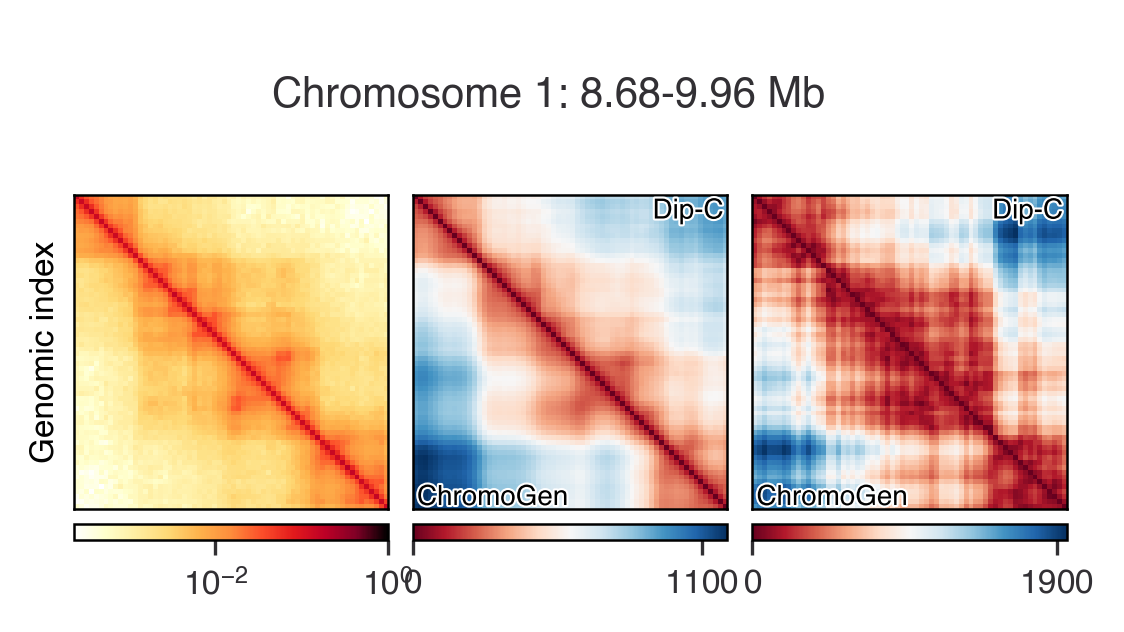

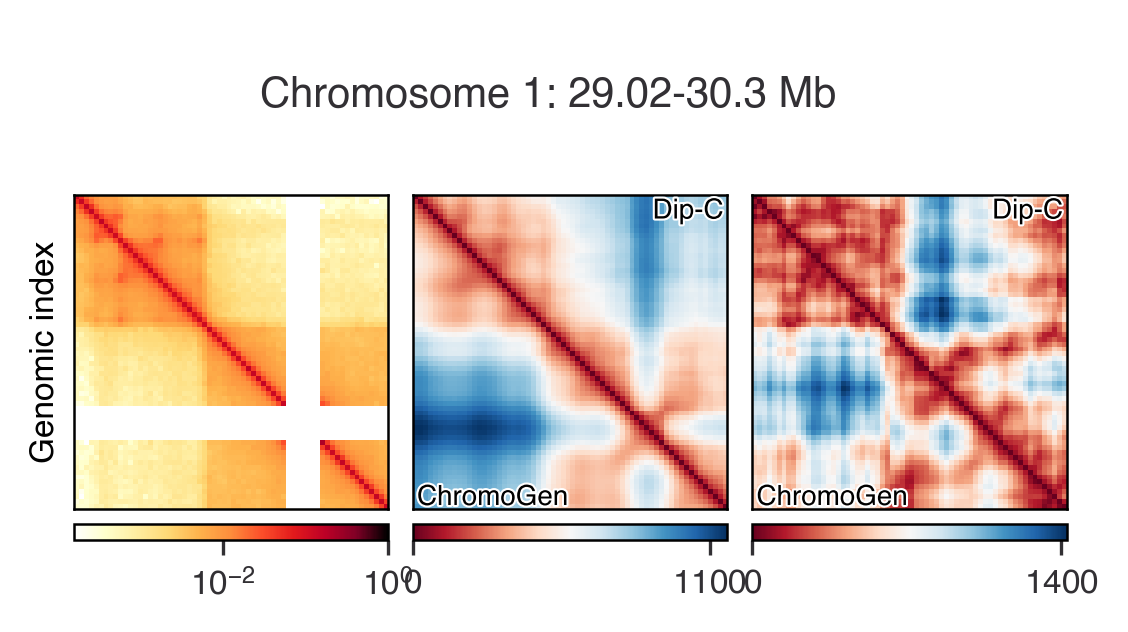

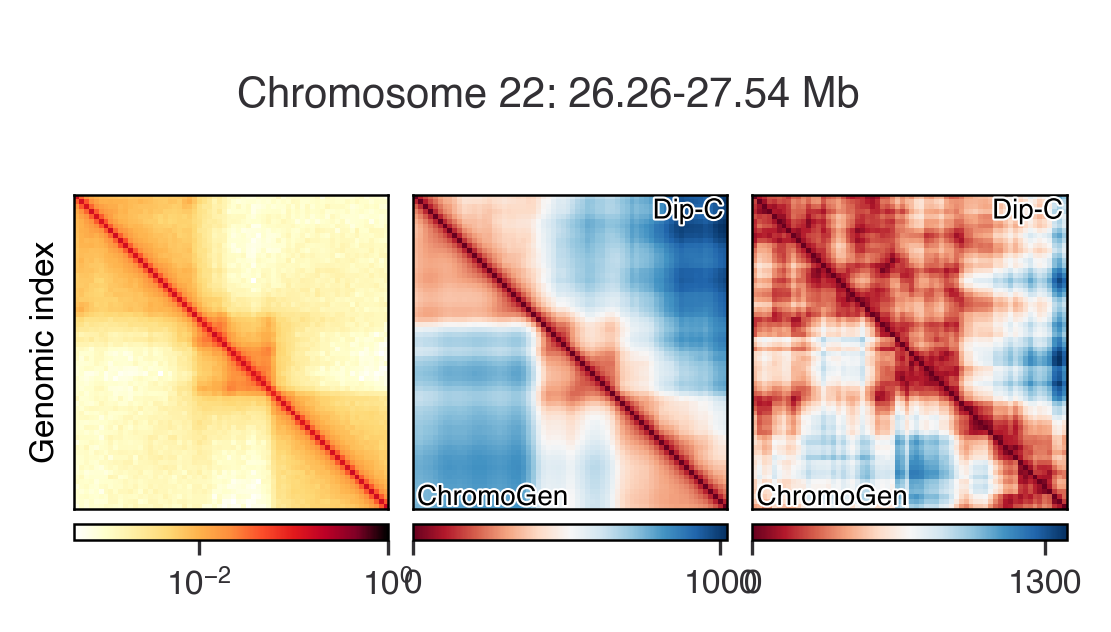

In [20]:
for chrom in regions:
    for region_idx,fp in regions[chrom]:


        if '5.0_8.0' not in fp: # Prevent duplicates from forming 
            continue
        
        # Parse to the final regions included in the paper
        if chrom not in ['1','22']:
            continue
        if chrom == '1':
            if region_idx not in [395,1325]:
                continue
        elif chrom == '22':
            if region_idx not in [464]:
                continue
        else:
            continue
        
        fig,*_ = gen_vs_tan_2(
            chrom,
            region_idx,
            .4,
            filepath=None,
            cond_scale=cond_scale,
            rescaled_phi=rescaled_phi,
            cbar_orientation='horizontal'
        )
        fig.savefig(
            save_dir + f'chrom_{chrom}_region_{region_idx}_nbins_{num_bins}_scale_{cond_scale}_phi_{rescaled_phi}_mixed.pdf',bbox_inches='tight',
            transparent=True
        );

#### Include the inferred Hi-C map

In [33]:
def to_hic(conformations,r_c=1.5,sigma=3.72,decay=3.45):
    
    p = conformations.distances.values.clone()
    mask = p < r_c
    p[mask] = ( 1 + ( sigma * (r_c - p[mask]) ).tanh() ) / 2
    mask^= True
    p[mask] = ( r_c / p[mask] ) ** decay

    return HiCMap(p.mean(0))
    

def gen_vs_tan_3(
    chrom=None,
    region_idx=None,
    fraction_w1=0.5,
    *,
    gen_configs = None,
    tan_configs = None,
    filepath=None,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    resolution=20_000,
    config_directory=config_directory,
    ax_titles=True,
    fig=None,
    hic_ax=None,
    dist_ax=None,
    fit_ax=None,
    cbar_orientation=None
):

    hic_map = get_experimental_hic(chrom,region_idx)
    hic_map.prob_map/= 0.0437 # Found by averaging off-diagonal in region 1
    '''
    if gen_configs is None:
        if filepath is None:
            gen_configs = get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone)
        else:
            gen_configs = Coordinates(filepath).distances
    '''

    
    gen_dists_w1 = get_gen_dists(filepath,chrom,region_idx,cond_scale=1.,rescaled_phi=0.,milestone=milestone)
    gen_hic = to_hic( gen_dists_w1 )
    gen_hic.prob_map*= fraction_w1
    gen_mean = gen_dists_w1.mean
    gen_mean._values*= fraction_w1
    del gen_dists_w1
    
    gen_dists_w5 =  get_gen_dists(filepath,chrom,region_idx,cond_scale=5.,rescaled_phi=8.,milestone=milestone)
    gen_hic.prob_map+= to_hic( gen_dists_w5 ).prob_map * (1-fraction_w1)
    gen_mean._values+= gen_dists_w5.mean.values * (1-fraction_w1)
    del gen_dists_w5
    
    gen_mean._values*= 100 # to nm
    n = gen_hic.prob_map.shape[-1]
    gen_hic.prob_map/= gen_hic.prob_map[range(n-1),range(1,n)].nanmean() # Normalize off-diagonal to 1, as in experiment

    if tan_configs is None:
        tan_configs, genomic_index = get_tan_dists(chrom,region_idx)
    else:
        genomic_index = get_genomic_index(chrom,region_idx)
    tan_configs = Distances(tan_configs.values*100) # convert to nm
    tan_mean = tan_configs.mean
    #tan_std = tan_configs.std
    del tan_configs

    if fig is None or hic_ax is None or dist_ax is None or fit_ax is None:
        if cbar_orientation is None:
            fig,(hic_ax,dist_ax,fit_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.6,6.692*.25),layout="constrained")
        else:
            fig,(hic_ax,dist_ax,fit_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.5,6.692*.25),layout="constrained")
            #fig,(hic_ax,dist_ax,fit_ax)=plt.subplots(ncols=3, nrows=1, figsize=(7.5*.5,6.692*.25),layout="constrained")
    
    _,_,hic_im,hic_cbar = hic_map.plot_with(gen_hic,fig=fig,ax=hic_ax,vmax=1,cbar_orientation=cbar_orientation)

    if cbar_orientation is None:
        cbar_ticks = None
    else:
        cbar_tick_max = int(max(tan_mean.values.max(),gen_mean.values.max())//100 * 100)
        cbar_ticks = [0,cbar_tick_max]
    _,_,dist_im,dist_cbar = tan_mean.plot_with(gen_mean,fig=fig,ax=dist_ax,cbar_orientation=cbar_orientation,cbar_ticks=cbar_ticks)
    dist_ax.set_ylabel('')

    _,_,fit_im,fit_cbar = plot_best_match(chrom,region_idx,cond_scale,rescaled_phi,milestone,filepath=filepath,fig=fig,ax=fit_ax,cbar_orientation=cbar_orientation)
    fit_ax.set_ylabel('')
    
    hic_cbar.set_label('')
    dist_cbar.set_label('')
    fit_cbar.set_label('')

    n = tan_mean.num_beads
    start_Mb = round(genomic_index/1e6,3)
    stop_Mb = round((genomic_index+resolution*n)/1e6,3)
    fig.suptitle(
        '\n'+f'Chromosome {chrom}: {start_Mb}-{stop_Mb} Mb',
        verticalalignment='center'
    )

    for ax,upper_label in [(dist_ax,'Dip-C'),(fit_ax,'Dip-C'),(hic_ax,'Experimental')]:
        
        ax.text(.995*n-1,.005*n,upper_label,horizontalalignment='right',verticalalignment='top',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],fontsize='small')
        
        ax.text(.005*n,.995*n-1,'ChromoGen',horizontalalignment='left',verticalalignment='baseline',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")],fontsize='small')

    return fig, dist_ax, dist_im, dist_cbar, hic_ax, hic_im, hic_cbar
    

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'M', 'b', 'c', 'colon', 'd', 'e', 'eight', 'h', 'hyphen', 'i', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'six', 'space', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 25, 27, 28, 29, 38, 42, 48, 69, 70, 71, 72, 75, 76, 80, 81, 82, 85, 86, 91, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'G', 'M', 'b', 'c', 'colon', 'd', 'e', 'eight', 'h', 'hyphen', 'i',

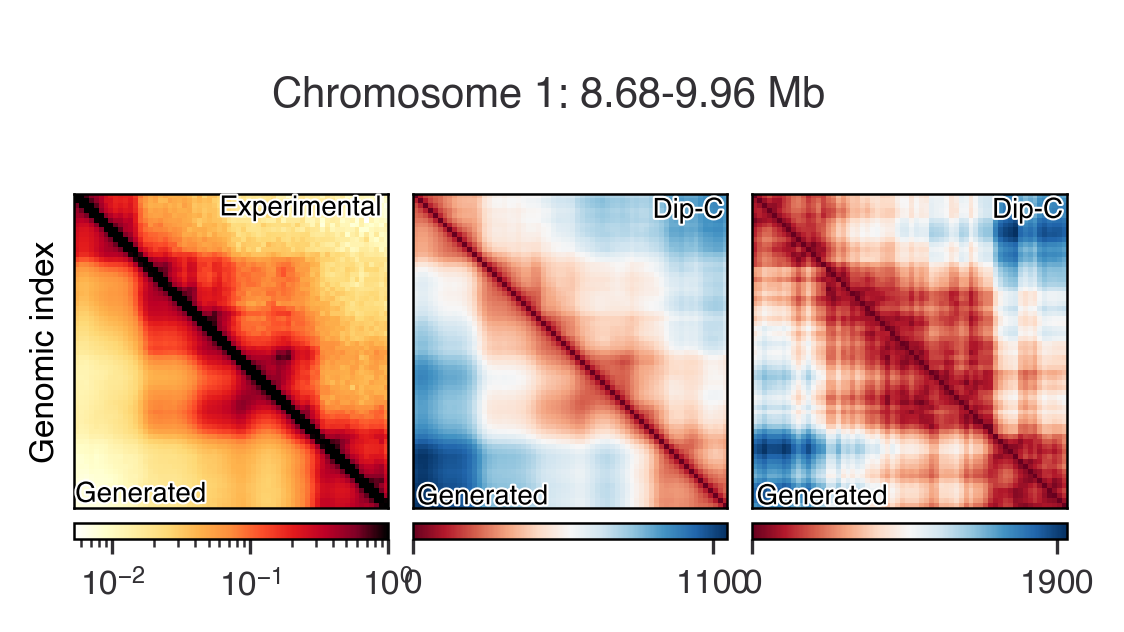

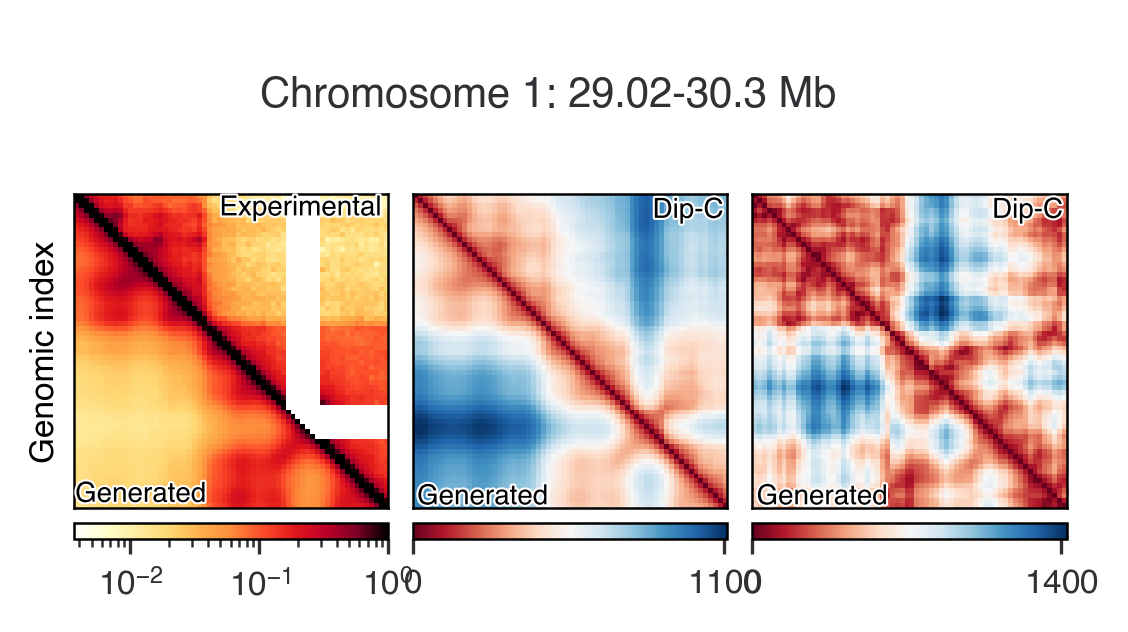

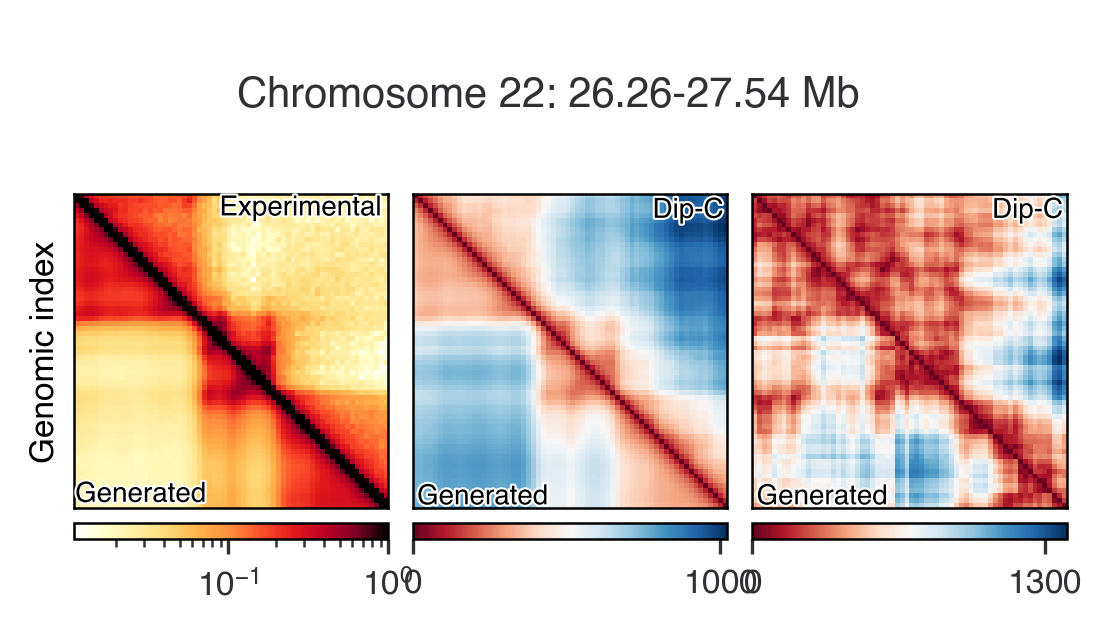

In [34]:
for chrom in regions:
    for region_idx,fp in regions[chrom]:


        if '5.0_8.0' not in fp: # Prevent duplicates from forming 
            continue
        
        # Parse to the final regions included in the paper
        if chrom not in ['1','22']:
            continue
        if chrom == '1':
            if region_idx not in [395,1325]:
                continue
        elif chrom == '22':
            if region_idx not in [464]:
                continue
        else:
            continue
        
        fig,*_ = gen_vs_tan_3(
            chrom,
            region_idx,
            .5,
            filepath=None,
            cond_scale=cond_scale,
            rescaled_phi=rescaled_phi,
            cbar_orientation='horizontal'
        )
        fig.savefig(
            save_dir + f'chrom_{chrom}_region_{region_idx}_nbins_{num_bins}_scale_{cond_scale}_phi_{rescaled_phi}_mixed_PTF.pdf',bbox_inches='tight',
            transparent=True
        );

#### Distance Maps

In [75]:
a = get_gen_dists(None,'X',1243,cond_scale,rescaled_phi,milestone)
a = Distances(a.values*100)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 22 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'G', 'a', 'c', 'd', 'e', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 's', 'seven', 'space', 't', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 26, 39, 42, 68, 70, 71, 72, 76, 80, 81, 82, 86, 87, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 22 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'G', 'a', 'c', 'd', 'e', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 's', 'seven', 'space', 't', 'x', 'zero']


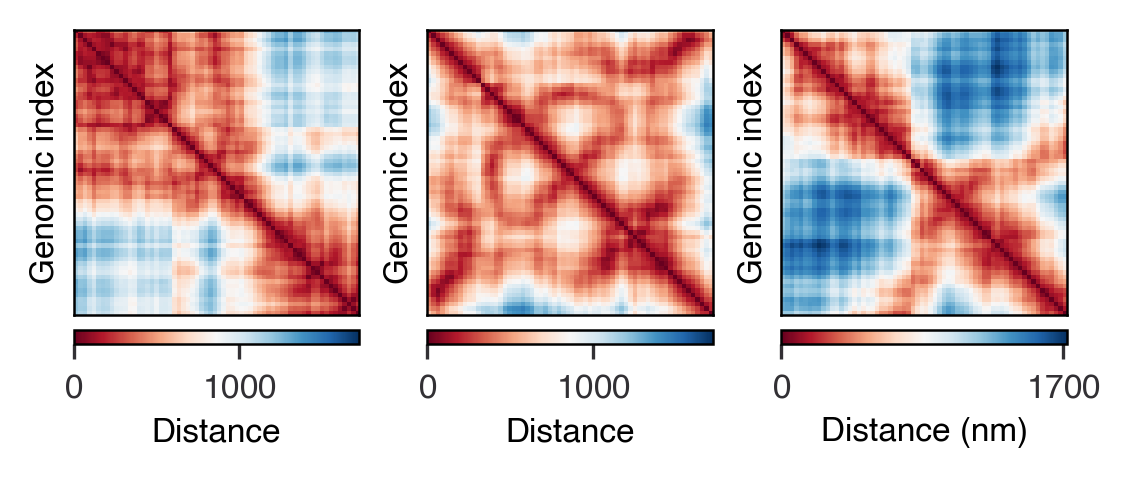

In [86]:
vmax = torch.cat([a[3].values,a[8].values,a[10].values,a[19].values],dim=0).max()

cbar_ticks = [0,int(vmax)//100*100]

fig,(ax0,ax1,ax2)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.5,6.692*.26),layout="constrained")
a[3].plot(fig=fig,ax=ax0,cbar_orientation='horizontal',vmax=vmax) # 8
a[8].plot(fig=fig,ax=ax1,cbar_orientation='horizontal',vmax=vmax) # 2?
*_,cbar = a[10].plot(fig=fig,ax=ax2,cbar_orientation='horizontal',vmax=vmax,cbar_ticks=cbar_ticks)
cbar.set_label('Distance (nm)')

for ax in [ax0,ax1,ax2]:
    ax.set_xlabel('')

fig.savefig(save_dir + 'conformations_1.pdf',bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'G', 'a', 'c', 'd', 'e', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 's', 'space', 't', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 39, 42, 68, 70, 71, 72, 76, 80, 81, 82, 86, 87, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 19 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'G', 'a', 'c', 'd', 'e', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 's', 'space', 't', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 39, 42, 68, 70, 71, 72, 76, 

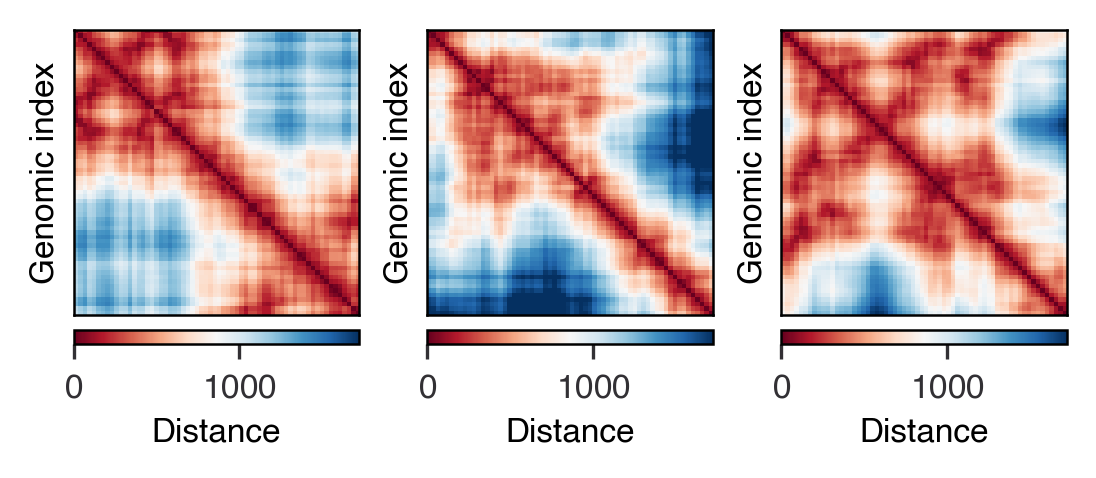

In [90]:
fig,(ax0,ax1,ax2)=plt.subplots(ncols=3, nrows=1, figsize=(7.08*.5,6.692*.26),layout="constrained")
a[22].plot(fig=fig,ax=ax0,cbar_orientation='horizontal',vmax=vmax) # 8
a[23].plot(fig=fig,ax=ax1,cbar_orientation='horizontal',vmax=vmax) # 2?
a[19].plot(fig=fig,ax=ax2,cbar_orientation='horizontal',vmax=vmax)

for ax in [ax0,ax1,ax2]:
    ax.set_xlabel('')
fig.savefig(save_dir + 'conformations_2.pdf',bbox_inches='tight')

In [ ]:
gen_coords = get_gen_coords('1',330).trajectory
tan_coords = get_tan_coords('1',330)[0].trajectory

In [ ]:
info1,aligned1 = gen_coords.get_best_superpositions(tan_coords)

In [ ]:
gen_coords.mdtraj.xyz[:,:,-1]*= -1
info2,aligned2 = gen_coords.get_best_superpositions(tan_coords)

In [ ]:
info1['RMSD'].min()

In [ ]:
info2['RMSD'].min()

In [93]:
(90.773-116.49) + 39.339

13.622

In [95]:
(-10.282+5.137) + 13.622

8.477